In [1]:
import os.path, json
from syrocr.images import Im, AvgIm
# https://stackoverflow.com/a/32370538
# usage: display(image)
from IPython.core.display import display

In [3]:
# img_dir = '../analyzevts/scans/genesis-exodus/exodus'
# json_dir = '../analyzevts/scans/genesis-exodus/exodus/lines'
# textlines_dir = '../analyzevts/scans/genesis-exodus/exodus/text'
img_dir = '../peshitta/syrocr/test_ephrem_mitchell'
json_dir = os.path.join(img_dir, 'lines')
src_img_ext = '.tif'
lines_file_ext = '_lines.json'
textlines_file_ext = '_textlines.json'
tables_file = os.path.join(json_dir, 'test_tables.json')
# tables_file = '../peshitta/syrocr/vts_3_2_jeremiah/test_tables.json'

with open(tables_file, 'r') as f:
    tables = json.load(f)

In [4]:
# TODO textsize should be available in line dict
def get_textsize(linetype, section):
    if section == 'main' and linetype in ('text', 'pagenr'):
        textsize = 'normal'
    else:
        textsize = 'small'
    return textsize

# we are mainly interested in the 'main' section,
# so for now we ignore 'marginl' and 'marginr'
section = 'main'

def get_filenames():
    with os.scandir(img_dir) as sd:
        for dir_entry in sorted(sd, key = lambda x: x.name):
            if dir_entry.is_file() and dir_entry.name.endswith(src_img_ext):
                basename = os.path.splitext(dir_entry.name)[0]
                img_file = dir_entry.path
                lines_file = os.path.join(json_dir, basename + lines_file_ext)
                textlines_file = os.path.join(json_dir, basename + textlines_file_ext)
                yield basename, img_file, lines_file, textlines_file

def get_key(basename, line_num, c_num, entry, table):
    c_id, d, keyoverride, box = entry
    c = table[c_id]
    
#     print(i, c_id, d, keyoverride, c['key'])

    if c['key'] is None:

        print(f'page {basename} line {line_num} character {c_num} id {c_id}')

        avgim = AvgIm(c['avgim']['base64_str'], c['avgim']['baseline'], c['avgim']['width'], c['avgim']['height'])
        display(avgim.maxtoblack(invert=True))

        key = input().split()

        table[c_id]['key'] = {
            'tr':     '' if not key else key.pop(0),
            'script': '' if not key or key[0].isdigit() else key.pop(0),
            'dist':   None if not key else int(key.pop(0)),
        }

        return table[c_id]['key']

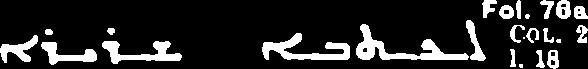

Line 2 textsize small


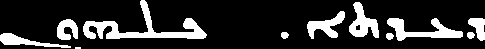

Line 3 textsize small


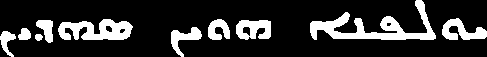

Line 4 textsize small


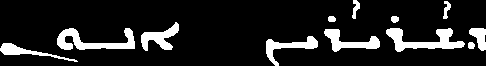

Line 5 textsize small


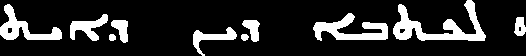

Line 6 textsize small


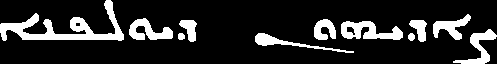

Line 7 textsize small


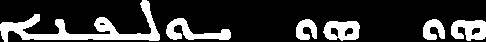

Line 8 textsize small


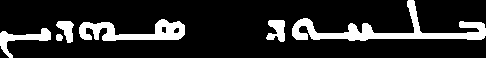

Line 9 textsize small


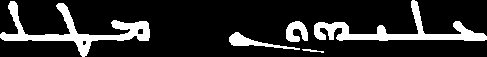

Line 10 textsize small


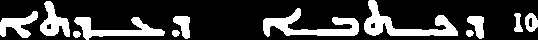

Line 11 textsize small


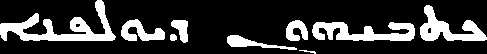

Line 12 textsize small


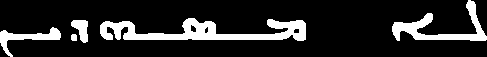

Line 13 textsize small


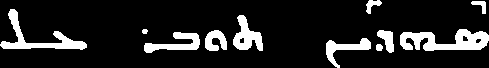

Line 14 textsize small


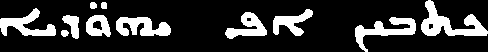

Line 15 textsize small


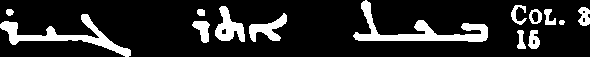

Line 16 textsize small


Line 17 textsize small


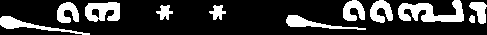

Line 18 textsize small


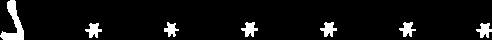

Line 19 textsize small


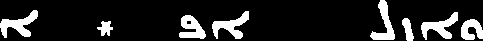

Line 20 textsize small


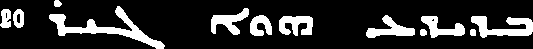

Line 21 textsize small


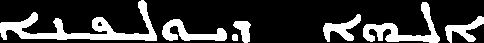

Line 22 textsize small


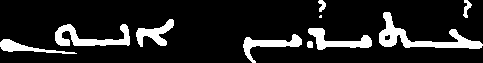

Line 23 textsize small


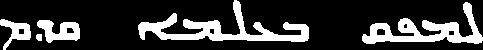

Line 24 textsize small


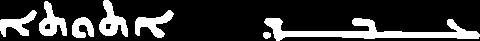

Line 25 textsize small


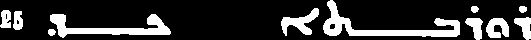

Line 26 textsize small


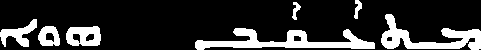

Line 27 textsize small


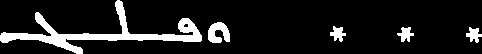

Line 28 textsize small


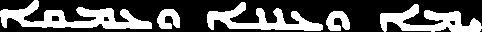

Line 29 textsize small


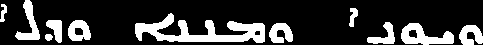

Line 30 textsize small


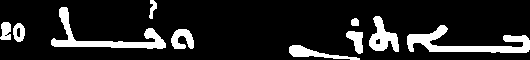

Line 31 textsize small


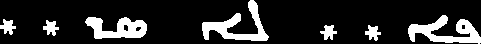

Line 32 textsize small


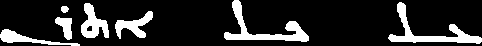

Line 33 textsize small


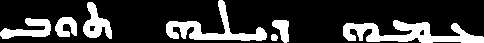

Line 34 textsize small


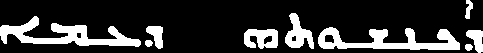

Line 35 textsize small


Line 36 textsize small


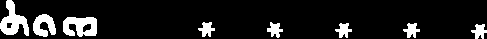

Line 37 textsize small


Line 1 textsize small


Line 2 textsize small


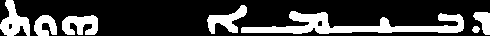

Line 3 textsize small


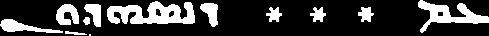

Line 4 textsize small


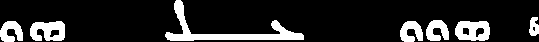

Line 5 textsize small


Line 6 textsize small


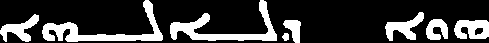

Line 7 textsize small


Line 8 textsize small


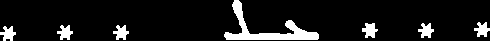

Line 9 textsize small


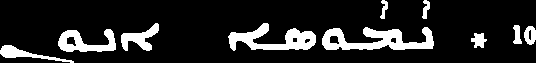

Line 10 textsize small


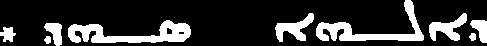

Line 11 textsize small


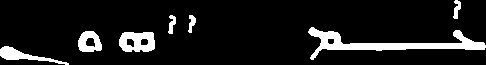

Line 12 textsize small


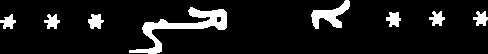

Line 13 textsize small


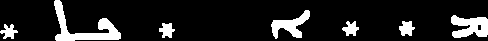

Line 14 textsize small


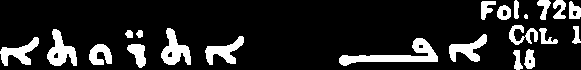

Line 15 textsize small


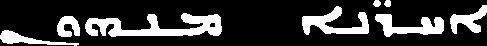

Line 16 textsize small


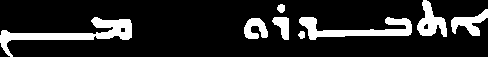

Line 17 textsize small


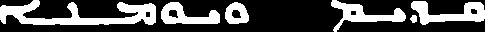

Line 18 textsize small


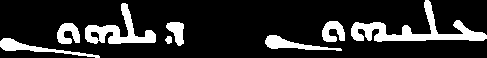

Line 19 textsize small


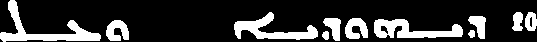

Line 20 textsize small


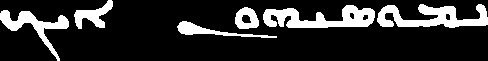

Line 21 textsize small


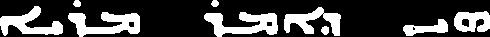

Line 22 textsize small


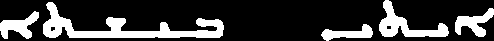

Line 23 textsize small


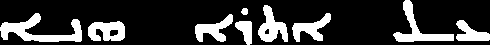

Line 24 textsize small


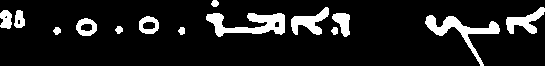

Line 25 textsize small


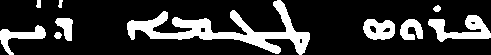

Line 26 textsize small


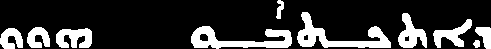

Line 27 textsize small


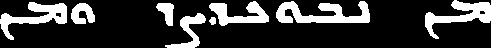

Line 28 textsize small


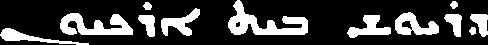

Line 29 textsize small


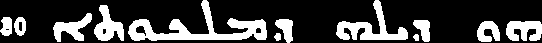

Line 30 textsize small


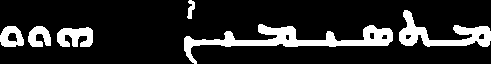

Line 31 textsize small


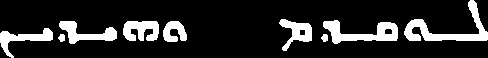

Line 32 textsize small


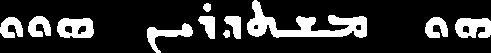

Line 33 textsize small


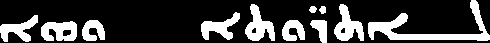

Line 34 textsize small


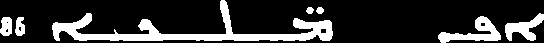

Line 35 textsize small


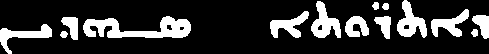

Line 36 textsize small


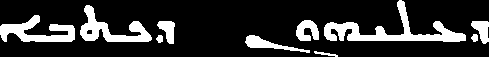

Line 37 textsize small


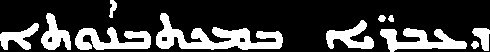

Line 38 textsize small


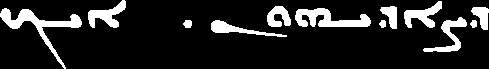

Line 39 textsize small


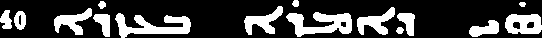

Line 40 textsize small


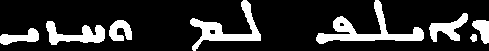

Line 41 textsize small


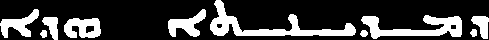

Line 42 textsize small


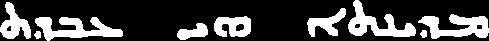

Line 43 textsize small


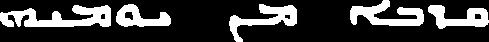

Line 44 textsize small


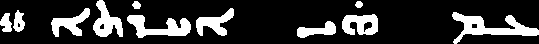

Line 45 textsize small


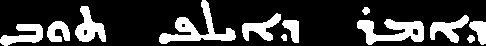

Line 46 textsize small


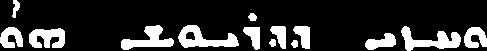

Line 47 textsize small


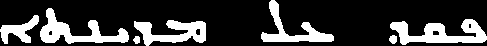

Line 48 textsize small


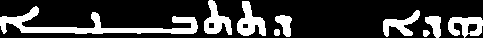

Line 1 textsize small


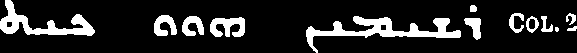

Line 2 textsize small


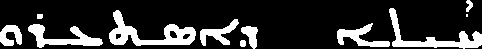

Line 3 textsize small


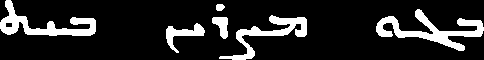

Line 4 textsize small


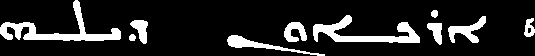

Line 5 textsize small


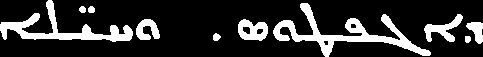

Line 6 textsize small


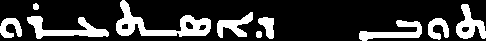

Line 7 textsize small


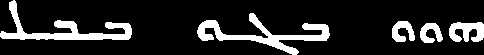

Line 8 textsize small


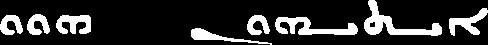

Line 9 textsize small


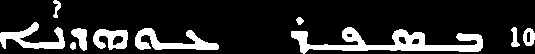

Line 10 textsize small


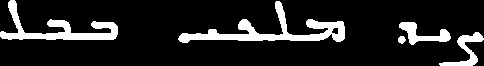

Line 11 textsize small


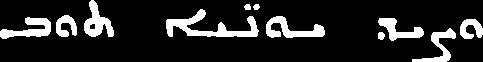

Line 12 textsize small


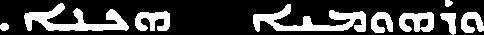

Line 13 textsize small


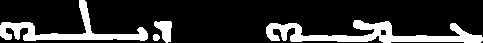

Line 14 textsize small


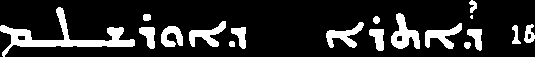

Line 15 textsize small


Line 16 textsize small


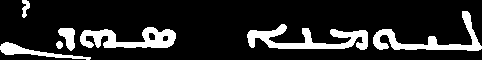

Line 17 textsize small


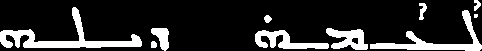

Line 18 textsize small


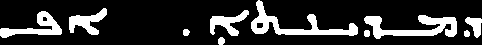

Line 19 textsize small


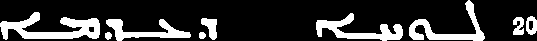

Line 20 textsize small


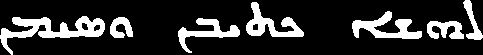

Line 21 textsize small


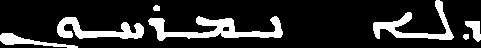

Line 22 textsize small


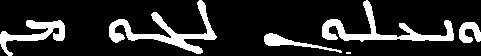

Line 23 textsize small


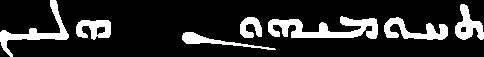

Line 24 textsize small


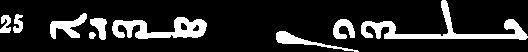

Line 25 textsize small


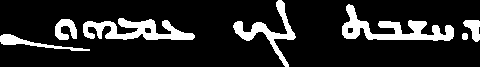

Line 26 textsize small


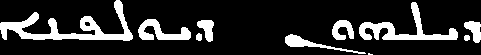

Line 27 textsize small


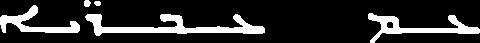

Line 28 textsize small


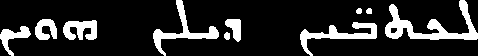

Line 29 textsize small


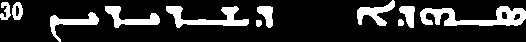

Line 30 textsize small


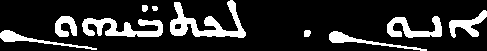

Line 31 textsize small


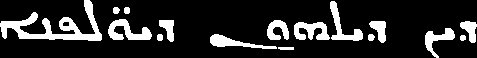

Line 32 textsize small


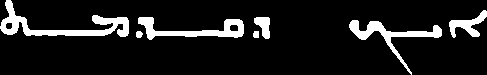

Line 33 textsize small


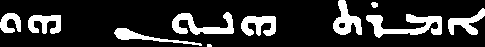

Line 34 textsize small


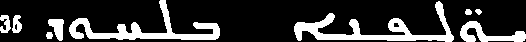

Line 35 textsize small


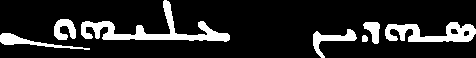

Line 36 textsize small


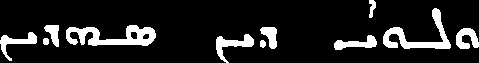

Line 37 textsize small


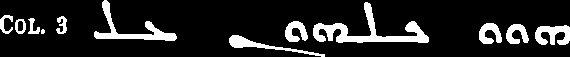

Line 38 textsize small


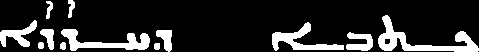

Line 39 textsize small


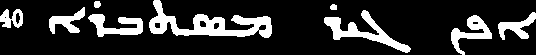

Line 40 textsize small


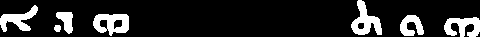

Line 41 textsize small


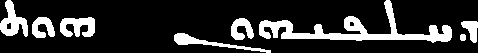

Line 42 textsize small


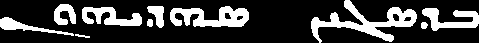

Line 43 textsize small


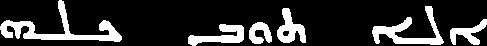

Line 44 textsize small


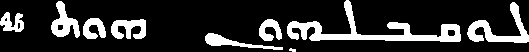

Line 45 textsize small


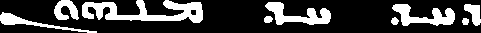

Line 46 textsize small


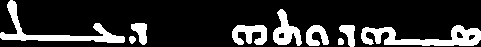

Line 47 textsize small


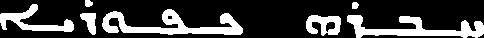

Line 48 textsize small


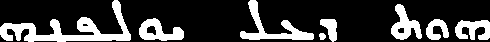

Line 1 textsize small


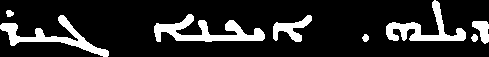

Line 2 textsize small


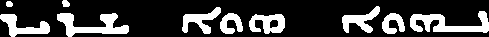

Line 3 textsize small


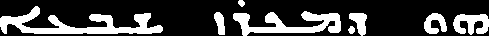

Line 4 textsize small


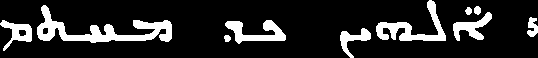

Line 5 textsize small


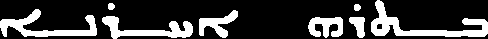

Line 6 textsize small


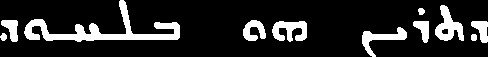

Line 7 textsize small


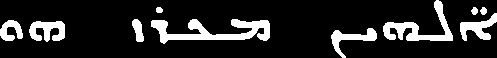

Line 8 textsize small


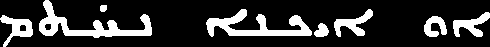

Line 9 textsize small


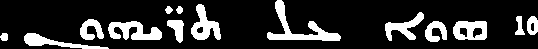

Line 10 textsize small


Line 11 textsize small


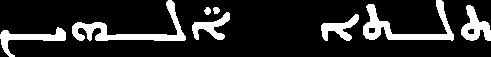

Line 12 textsize small


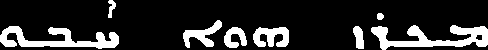

Line 13 textsize small


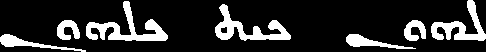

Line 14 textsize small


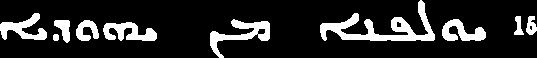

Line 15 textsize small


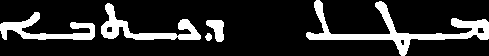

Line 16 textsize small


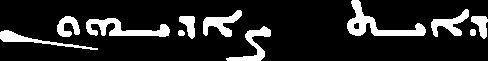

Line 17 textsize small


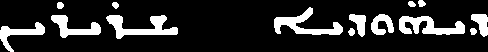

Line 18 textsize small


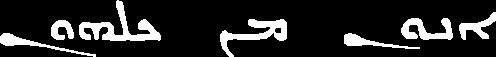

Line 19 textsize small


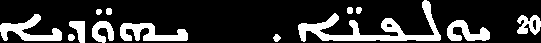

Line 20 textsize small


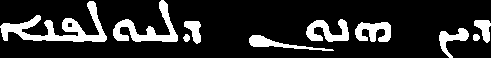

Line 21 textsize small


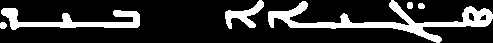

Line 22 textsize small


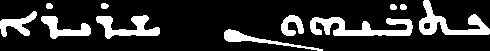

Line 23 textsize small


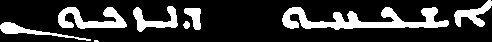

Line 24 textsize small


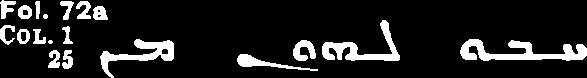

Line 25 textsize small


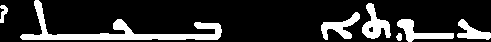

Line 26 textsize small


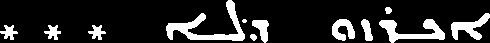

Line 27 textsize small


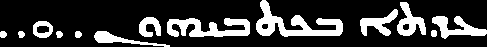

Line 28 textsize small


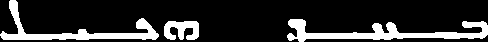

Line 29 textsize small


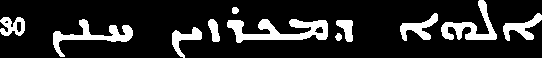

Line 30 textsize small


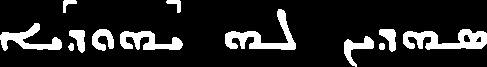

Line 31 textsize small


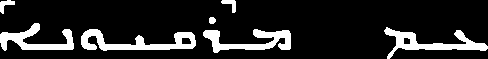

Line 32 textsize small


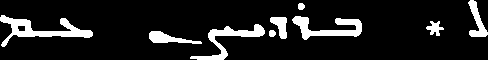

Line 33 textsize small


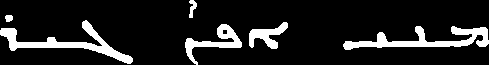

Line 34 textsize small


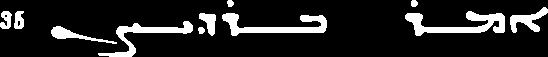

Line 35 textsize small


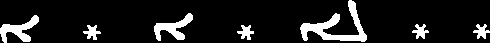

Line 36 textsize small


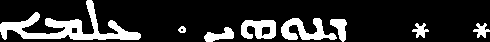

Line 37 textsize small


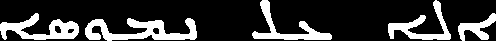

Line 38 textsize small


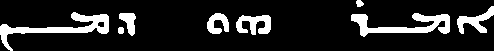

Line 39 textsize small


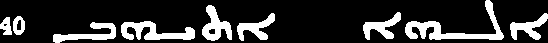

Line 40 textsize small


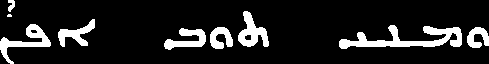

Line 41 textsize small


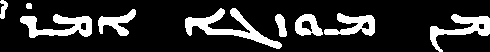

Line 42 textsize small


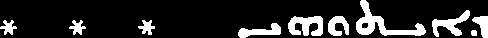

Line 43 textsize small


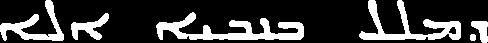

Line 44 textsize small


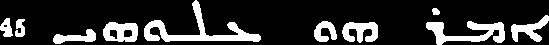

Line 45 textsize small


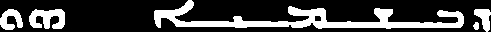

Line 46 textsize small


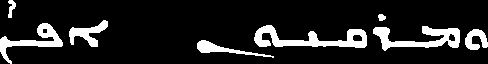

Line 47 textsize small


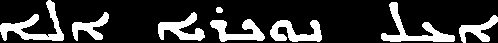

Line 48 textsize small


Line 1 textsize small


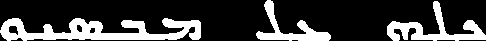

Line 2 textsize small


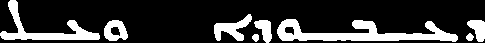

Line 3 textsize small


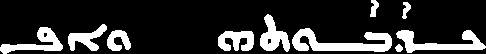

Line 4 textsize small


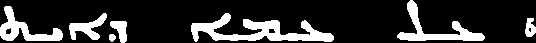

Line 5 textsize small


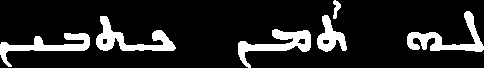

Line 6 textsize small


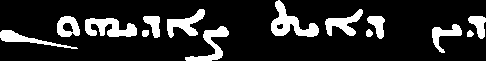

Line 7 textsize small


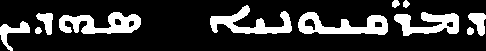

Line 8 textsize small


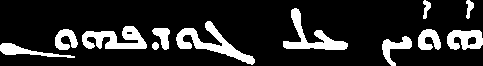

Line 9 textsize small


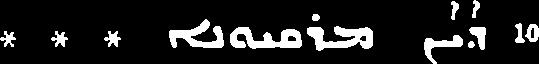

Line 10 textsize small


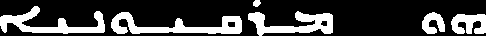

Line 11 textsize small


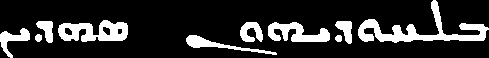

Line 12 textsize small


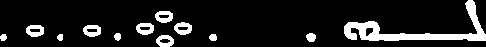

Line 13 textsize small


Line 14 textsize small


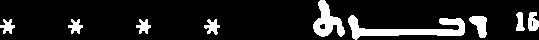

Line 15 textsize small


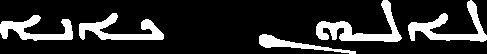

Line 16 textsize small


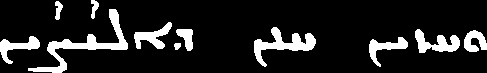

Line 17 textsize small
page mitchell2_test-05 line 17 character 7 id 449


+H
{'tr': '+H', 'script': '', 'dist': None}
page mitchell2_test-05 line 17 character 8 id 450


yN
{'tr': 'yN', 'script': '', 'dist': None}
page mitchell2_test-05 line 17 character 9 id 451


z
{'tr': 'z', 'script': '', 'dist': None}


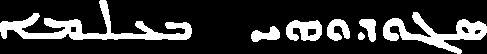

Line 18 textsize small


Line 19 textsize small
page mitchell2_test-05 line 19 character 5 id 452


'
{'tr': "'", 'script': '', 'dist': None}


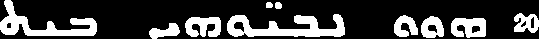

Line 20 textsize small
page mitchell2_test-05 line 20 character 6 id 453


y"
{'tr': 'y"', 'script': '', 'dist': None}
page mitchell2_test-05 line 20 character 7 id 454


b
{'tr': 'b', 'script': '', 'dist': None}
page mitchell2_test-05 line 20 character 8 id 455


n
{'tr': 'n', 'script': '', 'dist': None}


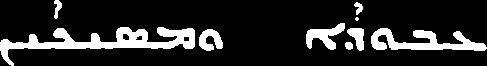

Line 21 textsize small
page mitchell2_test-05 line 21 character 2 id 456


msyk
{'tr': 'msyk', 'script': '', 'dist': None}
page mitchell2_test-05 line 21 character 6 id 457


d
{'tr': 'd', 'script': '', 'dist': None}


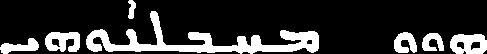

Line 22 textsize small
page mitchell2_test-05 line 22 character 3 id 421


n
{'tr': 'n', 'script': '', 'dist': None}
page mitchell2_test-05 line 22 character 10 id 458


q
{'tr': 'q', 'script': '', 'dist': None}


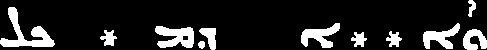

Line 23 textsize small
page mitchell2_test-05 line 23 character 9 id 459


w
{'tr': 'w', 'script': '', 'dist': None}


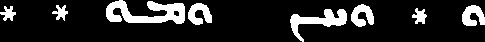

Line 24 textsize small
page mitchell2_test-05 line 24 character 2 id 460


w
{'tr': 'w', 'script': '', 'dist': None}
page mitchell2_test-05 line 24 character 5 id 461


N
{'tr': 'N', 'script': '', 'dist': None}


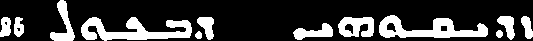

Line 25 textsize small
page mitchell2_test-05 line 25 character 9 id 462


yqw
{'tr': 'yqw', 'script': '', 'dist': None}


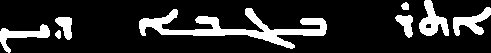

Line 26 textsize small
page mitchell2_test-05 line 26 character 0 id 463


N
{'tr': 'N', 'script': '', 'dist': None}
page mitchell2_test-05 line 26 character 4 id 464


b
{'tr': 'b', 'script': '', 'dist': None}
page mitchell2_test-05 line 26 character 6 id 465


b
{'tr': 'b', 'script': '', 'dist': None}


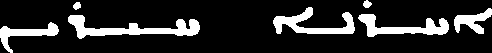

Line 27 textsize small
page mitchell2_test-05 line 27 character 5 id 466


n'
{'tr': "n'", 'script': '', 'dist': None}
page mitchell2_test-05 line 27 character 6 id 467


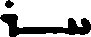

Hr
{'tr': 'Hr', 'script': '', 'dist': None}


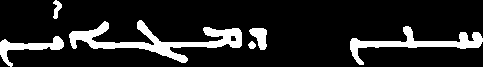

Line 28 textsize small
page mitchell2_test-05 line 28 character 3 id 468


'
{'tr': "'", 'script': '', 'dist': None}
page mitchell2_test-05 line 28 character 4 id 469


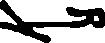

mg
{'tr': 'mg', 'script': '', 'dist': None}
page mitchell2_test-05 line 28 character 6 id 470


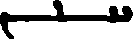

HnN
{'tr': 'HnN', 'script': '', 'dist': None}


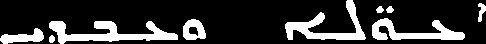

Line 29 textsize small
page mitchell2_test-05 line 29 character 1 id 471


d
{'tr': 'd', 'script': '', 'dist': None}
page mitchell2_test-05 line 29 character 5 id 472


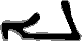

l'
{'tr': "l'", 'script': '', 'dist': None}
page mitchell2_test-05 line 29 character 6 id 473


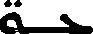

`w"
{'tr': '`w"', 'script': '', 'dist': None}


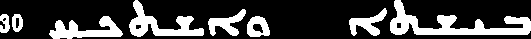

Line 30 textsize small
page mitchell2_test-05 line 30 character 2 id 474


H
{'tr': 'H', 'script': '', 'dist': None}
page mitchell2_test-05 line 30 character 3 id 475


k
{'tr': 'k', 'script': '', 'dist': None}
page mitchell2_test-05 line 30 character 9 id 476


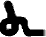

t
{'tr': 't', 'script': '', 'dist': None}
page mitchell2_test-05 line 30 character 12 id 477


b
{'tr': 'b', 'script': '', 'dist': None}


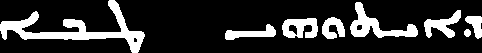

Line 31 textsize small
page mitchell2_test-05 line 31 character 2 id 478


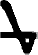

T
{'tr': 'T', 'script': '', 'dist': None}
page mitchell2_test-05 line 31 character 3 id 479


y
{'tr': 'y', 'script': '', 'dist': None}
page mitchell2_test-05 line 31 character 6 id 480


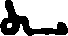

yt
{'tr': 'yt', 'script': '', 'dist': None}


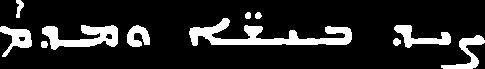

Line 32 textsize small
page mitchell2_test-05 line 32 character 6 id 481


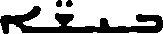

by$"'
{'tr': 'by$"\'', 'script': '', 'dist': None}
page mitchell2_test-05 line 32 character 7 id 482


yd
{'tr': 'yd', 'script': '', 'dist': None}


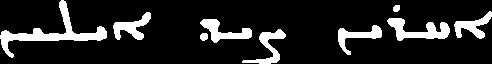

Line 33 textsize small
page mitchell2_test-05 line 33 character 3 id 483


y
{'tr': 'y', 'script': '', 'dist': None}
page mitchell2_test-05 line 33 character 5 id 484


yd
{'tr': 'yd', 'script': '', 'dist': None}
page mitchell2_test-05 line 33 character 8 id 485


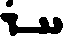

Hr
{'tr': 'Hr', 'script': '', 'dist': None}


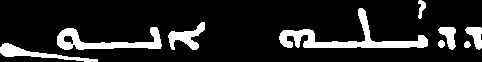

Line 34 textsize small
page mitchell2_test-05 line 34 character 6 id 486


y
{'tr': 'y', 'script': '', 'dist': None}


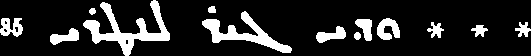

Line 35 textsize small
page mitchell2_test-05 line 35 character 0 id 487



{'tr': '', 'script': '', 'dist': None}
page mitchell2_test-05 line 35 character 1 id 488



{'tr': '', 'script': '', 'dist': None}
page mitchell2_test-05 line 35 character 5 id 489


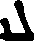

ln
{'tr': 'ln', 'script': '', 'dist': None}
page mitchell2_test-05 line 35 character 13 id 490


*
{'tr': '*', 'script': '', 'dist': None}


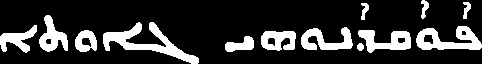

Line 36 textsize small
page mitchell2_test-05 line 36 character 7 id 491


nw
{'tr': 'nw', 'script': '', 'dist': None}
page mitchell2_test-05 line 36 character 8 id 492


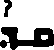

qd
{'tr': 'qd', 'script': '', 'dist': None}
page mitchell2_test-05 line 36 character 9 id 493


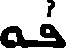

pw
{'tr': 'pw', 'script': '', 'dist': None}


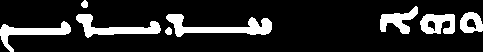

Line 37 textsize small
page mitchell2_test-05 line 37 character 0 id 494


yN
{'tr': 'yN', 'script': '', 'dist': None}
page mitchell2_test-05 line 37 character 3 id 495


Hd
{'tr': 'Hd', 'script': '', 'dist': None}


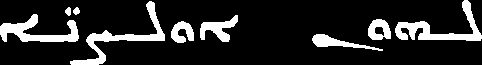

Line 38 textsize small
page mitchell2_test-05 line 38 character 6 id 496


N+
{'tr': 'N+', 'script': '', 'dist': None}
page mitchell2_test-05 line 38 character 7 id 497


+N
{'tr': '+N', 'script': '', 'dist': None}
page mitchell2_test-05 line 38 character 9 id 498


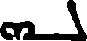

lh
{'tr': 'lh', 'script': '', 'dist': None}


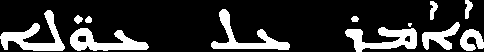

Line 39 textsize small
page mitchell2_test-05 line 39 character 2 id 499


w"
{'tr': 'w"', 'script': '', 'dist': None}
page mitchell2_test-05 line 39 character 7 id 500


m
{'tr': 'm', 'script': '', 'dist': None}


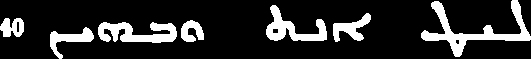

Line 40 textsize small
page mitchell2_test-05 line 40 character 0 id 501



{'tr': '', 'script': '', 'dist': None}
page mitchell2_test-05 line 40 character 5 id 502


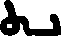

nt
{'tr': 'nt', 'script': '', 'dist': None}
page mitchell2_test-05 line 40 character 7 id 503


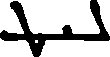

lyT
{'tr': 'lyT', 'script': '', 'dist': None}


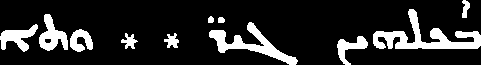

Line 41 textsize small
page mitchell2_test-05 line 41 character 12 id 504


bk
{'tr': 'bk', 'script': '', 'dist': None}


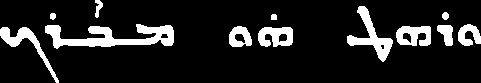

Line 42 textsize small
page mitchell2_test-05 line 42 character 0 id 505


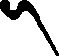

K
{'tr': 'K', 'script': '', 'dist': None}
page mitchell2_test-05 line 42 character 1 id 506


mbD?
{'tr': 'mbD?', 'script': '', 'dist': None}
page mitchell2_test-05 line 42 character 6 id 507


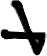

T
{'tr': 'T', 'script': '', 'dist': None}


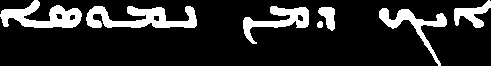

Line 43 textsize small
page mitchell2_test-05 line 43 character 8 id 508


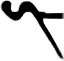

K
{'tr': 'K', 'script': '', 'dist': None}


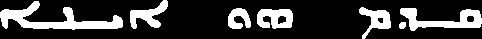

Line 44 textsize small
page mitchell2_test-05 line 44 character 7 id 509


d
{'tr': 'd', 'script': '', 'dist': None}


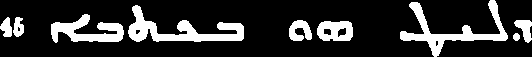

Line 45 textsize small
page mitchell2_test-05 line 45 character 0 id 510



{'tr': '', 'script': '', 'dist': None}
page mitchell2_test-05 line 45 character 2 id 511


b
{'tr': 'b', 'script': '', 'dist': None}


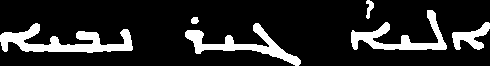

Line 46 textsize small
page mitchell2_test-05 line 46 character 3 id 512


n
{'tr': 'n', 'script': '', 'dist': None}
page mitchell2_test-05 line 46 character 6 id 513


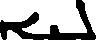

ly'
{'tr': "ly'", 'script': '', 'dist': None}


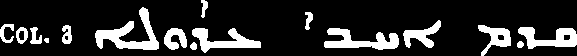

Line 47 textsize small
page mitchell2_test-05 line 47 character 6 id 514


l
{'tr': 'l', 'script': '', 'dist': None}
page mitchell2_test-05 line 47 character 8 id 515


d
{'tr': 'd', 'script': '', 'dist': None}
page mitchell2_test-05 line 47 character 9 id 516


`
{'tr': '`', 'script': '', 'dist': None}
page mitchell2_test-05 line 47 character 16 id 517


qd
{'tr': 'qd', 'script': '', 'dist': None}


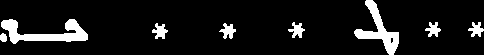

Line 48 textsize small


Line 1 textsize small


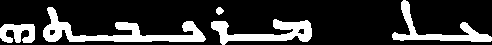

Line 2 textsize small


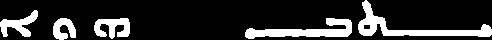

Line 3 textsize small
page mitchell2_test-06 line 3 character 3 id 521


KeyboardInterrupt: 

In [22]:
for basename, img_file, lines_file, textlines_file in get_filenames():
    im = Im(img_file)
    with open(lines_file, 'r') as f:
        lines = json.load(f)
    with open(textlines_file, 'r') as f:
        text = json.load(f)

    for line, textline in zip(lines, text):
        if line['type'] != 'column' or line['main'] is None:
            continue
        textsize = get_textsize(line['type'], section)
        table = tables[textsize]
        display(im.crop(line['main']))
        print('Line', line['num'], 'textsize', textsize)
        for i, entry in enumerate(textline[section]):
            key = get_key(basename, line['num'], i, entry, table)
            if key is not None:
                print(key)
#
# Final letters: kaf, indicated with capital K; nun, indicated with capital N; mem, capital M
# Dotless dalath/rish: indicated with capital D
# TODO misplaced dot below Sade, that should be shifted from before to after Sade: #>
# TODO misplaced? dot below mem (with dot above), that properly belongs to following nun(?): m^# (id 312)

In [41]:
tables['small'][282]['key']['tr']

'+N'

In [42]:
# dialogue to prevent accidental writing to tables file
if input(f'Type \'yes indeed\' to save the tables dict to {tables_file}:\n') == 'yes indeed':
    with open(tables_file, 'w') as f:
        json.dump(tables, f)
    print('Saved!')
else:
    print('Not saved.')

Type 'yes indeed' to save the tables dict to ../peshitta/syrocr/test_ephrem_mitchell/lines/test_tables.json:
yes indeed
Saved!


prev: [164, [False, True], None, [999, 1186, 1032, 1218]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-02 13 4 [36, [True, True], None, [1028, 1183, 1038, 1194]] {'tr': 'y', 'script': '', 'dist': None}


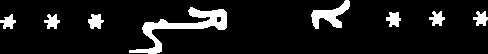

prev: [227, [False, True], None, [1296, 1008, 1335, 1039]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-03 11 8 [12, [True, False], None, [1297, 1002, 1308, 1015]] {'tr': 'y', 'script': '', 'dist': None}


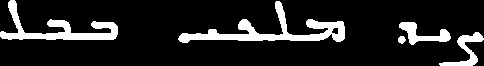

prev: [227, [False, True], None, [1269, 1091, 1308, 1121]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-03 12 10 [36, [True, False], None, [1271, 1086, 1281, 1100]] {'tr': 'y', 'script': '', 'dist': None}


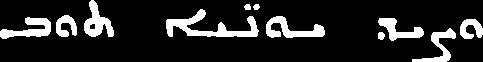

prev: [227, [False, True], None, [1079, 1518, 1118, 1549]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-04 17 8 [36, [True, False], None, [1113, 1514, 1124, 1525]] {'tr': 'y', 'script': '', 'dist': None}


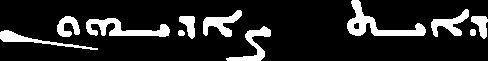

prev: [227, [False, True], None, [258, 1028, 296, 1059]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-04 35 5 [36, [True, True], None, [292, 1025, 301, 1036]] {'tr': 'y', 'script': '', 'dist': None}


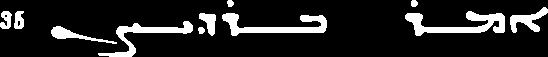

In [47]:
# search for ambiguously encoded characters
page = 0
for basename, img_file, lines_file, textlines_file in get_filenames():
    if page > 4:
        break
    page += 1
#     im = Im(img_file)
    with open(lines_file, 'r') as f:
        lines = json.load(f)
    with open(textlines_file, 'r') as f:
        text = json.load(f)
        
    for line, textline in zip(lines, text):
        if line['type'] != 'column':
            continue
        textsize = get_textsize(line['type'], section)
        table = tables[textsize]
        stack = None
        for i, entry in enumerate(textline[section]):
            c_id, connections, keyoverride, box = entry
            tr = table[c_id]['key']['tr'] if table[c_id]['key'] else None
            pr_tr = table[stack[0]]['key']['tr'] if stack and table[stack[0]]['key'] else None

            ### SEARCH LOCATION ###
#             if basename == 'mitchell2_test-05' and line['num'] == 44 and i in range(0,18): # tr == '$': # i == 14: # 
#                 print(basename, line['num'], i, entry, table[c_id]['key'])

            ### SEARCH C_ID ###
#             if c_id == 290:
#             if stack and stack[0] == 159:
#             if stack and pr_tr == '+S?N':
            if tr == 'y' and stack and pr_tr == 'S':
                if stack:
                    print('prev:', stack, table[stack[0]]['key'])
                print(basename, line['num'], i, entry, table[c_id]['key'])
                im = Im(img_file)
                display(im.crop(line['main']))
            stack = entry

#             if tr == 'w' and connections[0]:
#                 if stack:
#                     print('prev:', stack, table[stack[0]]['key'])
#                 print(basename, line['num'], i, entry, table[c_id]['key'])
# #                 print(f'  - [[\'{basename}\', {line["num"]}, {i}, {c_id}], \'q\']')
#                 im = Im(img_file)
#                 display(im.crop(line['main']))
#             stack = entry


prev: [45, [True, False], None, [1151, 909, 1177, 922]] {'tr': 'y', 'script': '', 'dist': None}
mitchell2_test-01 5 7 [46, [False, False], None, [1183, 902, 1239, 925]] {'tr': 'yD?', 'script': '', 'dist': None}


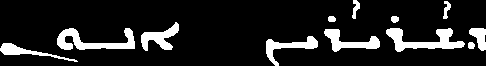

prev: [46, [False, False], None, [1183, 902, 1239, 925]] {'tr': 'yD?', 'script': '', 'dist': None}
mitchell2_test-01 5 8 [47, [False, False], None, [1187, 889, 1195, 895]] {'tr': '^?', 'script': '', 'dist': None}


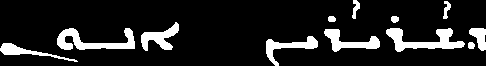

prev: [47, [False, False], None, [1187, 889, 1195, 895]] {'tr': '^?', 'script': '', 'dist': None}
mitchell2_test-01 5 9 [48, [False, False], None, [1211, 873, 1219, 892]] {'tr': '', 'script': '', 'dist': None}


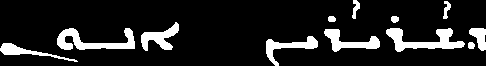

prev: [48, [False, False], None, [1211, 873, 1219, 892]] {'tr': '', 'script': '', 'dist': None}
mitchell2_test-01 5 10 [49, [False, False], None, [1245, 901, 1324, 925]] {'tr': '$D?', 'script': '', 'dist': None}


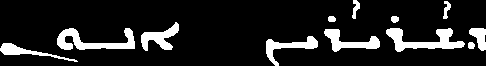

prev: [49, [False, False], None, [1245, 901, 1324, 925]] {'tr': '$D?', 'script': '', 'dist': None}
mitchell2_test-01 5 11 [47, [False, False], None, [1250, 889, 1258, 896]] {'tr': '^?', 'script': '', 'dist': None}


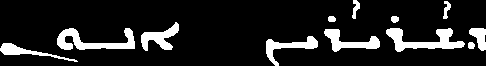

prev: [47, [False, False], None, [1250, 889, 1258, 896]] {'tr': '^?', 'script': '', 'dist': None}
mitchell2_test-01 5 12 [48, [False, False], None, [1302, 874, 1310, 892]] {'tr': '', 'script': '', 'dist': None}


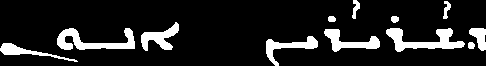

prev: [121, [False, False], None, [269, 1640, 285, 1656]] {'tr': '*', 'script': '', 'dist': None}
mitchell2_test-01 32 2 [122, [False, False], None, [311, 1637, 373, 1659]] {'tr': 'sD?', 'script': '', 'dist': None}


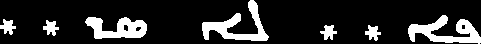

prev: [40, [True, False], None, [1057, 428, 1068, 450]] {'tr': 'n', 'script': '', 'dist': None}
mitchell2_test-02 4 6 [149, [False, False], None, [1073, 429, 1091, 453]] {'tr': 'D?', 'script': '', 'dist': None}


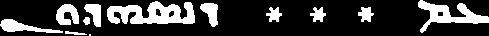

prev: [39, [False, False], None, [300, 432, 324, 453]] {'tr': 'w', 'script': '', 'dist': None}
mitchell2_test-02 28 3 [149, [False, False], None, [385, 432, 403, 455]] {'tr': 'D?', 'script': '', 'dist': None}


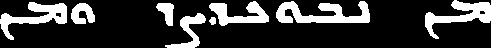

prev: [211, [False, True], None, [413, 652, 426, 716]] {'tr': 'N', 'script': '', 'dist': None}
mitchell2_test-02 31 4 [59, [True, True], None, [453, 683, 464, 699]] {'tr': '+H', 'script': '', 'dist': None}


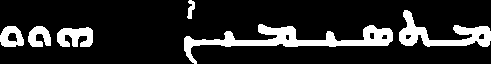

prev: [227, [False, True], None, [649, 1351, 687, 1383]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-02 39 12 [228, [True, False], None, [683, 1348, 693, 1358]] {'tr': '+S?', 'script': '', 'dist': None}


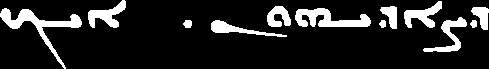

prev: [15, [True, False], None, [623, 1749, 650, 1768]] {'tr': 'b', 'script': '', 'dist': None}
mitchell2_test-02 44 9 [240, [False, True], None, [654, 1747, 712, 1771]] {'tr': 'D?', 'script': '', 'dist': None}


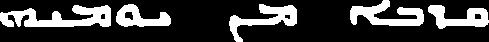

prev: [227, [False, True], None, [1074, 435, 1110, 466]] {'tr': 'S', 'script': '', 'dist': None}
mitchell2_test-03 4 5 [228, [True, True], None, [1106, 432, 1115, 442]] {'tr': '+S?', 'script': '', 'dist': None}


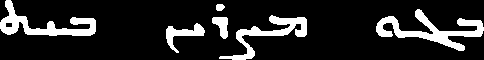

prev: [275, [True, True], None, [1200, 581, 1286, 619]] {'tr': 'gp+', 'script': '', 'dist': None}
mitchell2_test-03 6 8 [276, [True, False], None, [1236, 577, 1264, 605]] {'tr': '+g', 'script': '', 'dist': None}


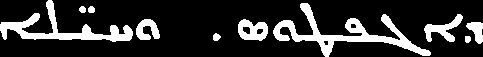

prev: [12, [True, False], None, [1297, 1002, 1308, 1015]] {'tr': 'y', 'script': '', 'dist': None}
mitchell2_test-03 11 9 [228, [True, False], None, [1330, 1005, 1341, 1015]] {'tr': '+S?', 'script': '', 'dist': None}


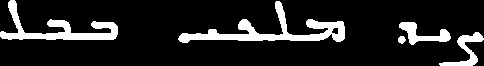

prev: [36, [True, False], None, [1271, 1086, 1281, 1100]] {'tr': 'y', 'script': '', 'dist': None}
mitchell2_test-03 12 11 [228, [True, False], None, [1303, 1087, 1313, 1098]] {'tr': '+S?', 'script': '', 'dist': None}


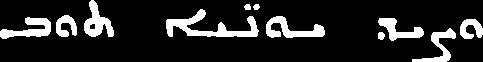

prev: [43, [False, True], None, [859, 1499, 884, 1512]] {'tr': 'N+', 'script': '', 'dist': None}
mitchell2_test-03 17 1 [48, [False, False], None, [881, 1457, 889, 1475]] {'tr': '', 'script': '', 'dist': None}


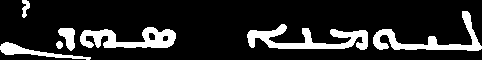

prev: [48, [False, False], None, [881, 1457, 889, 1475]] {'tr': '', 'script': '', 'dist': None}
mitchell2_test-03 17 2 [290, [True, False], None, [897, 1506, 950, 1517]] {'tr': '+N', 'script': '', 'dist': None}


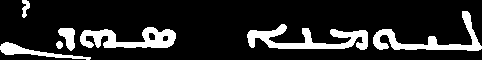

prev: [12, [True, False], None, [266, 594, 277, 607]] {'tr': 'y', 'script': '', 'dist': None}
mitchell2_test-03 30 4 [320, [False, True], None, [283, 588, 299, 610]] {'tr': 'D?', 'script': '', 'dist': None}


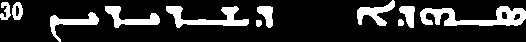

prev: [12, [True, False], None, [328, 595, 338, 610]] {'tr': 'y', 'script': '', 'dist': None}
mitchell2_test-03 30 6 [320, [False, True], None, [344, 588, 361, 610]] {'tr': 'D?', 'script': '', 'dist': None}


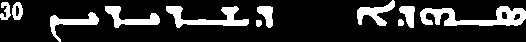

prev: [111, [True, False], None, [388, 771, 410, 790]] {'tr': 'q', 'script': '', 'dist': None}
mitchell2_test-04 32 6 [149, [False, True], None, [417, 769, 434, 792]] {'tr': 'D?', 'script': '', 'dist': None}


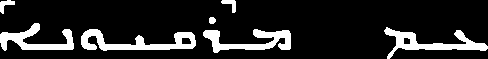

prev: [149, [False, True], None, [417, 769, 434, 792]] {'tr': 'D?', 'script': '', 'dist': None}
mitchell2_test-04 32 7 [47, [False, False], None, [423, 756, 430, 763]] {'tr': '^?', 'script': '', 'dist': None}


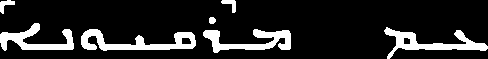

prev: [47, [False, False], None, [423, 756, 430, 763]] {'tr': '^?', 'script': '', 'dist': None}
mitchell2_test-04 32 8 [73, [False, False], None, [435, 739, 450, 752]] {'tr': '', 'script': '', 'dist': None}


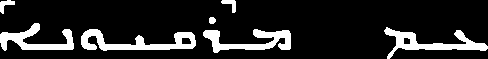

prev: [32, [False, False], None, [1060, 1168, 1068, 1175]] {'tr': '=.', 'script': '', 'dist': None}
mitchell2_test-05 13 9 [228, [False, False], None, [1157, 1167, 1167, 1176]] {'tr': '+S?', 'script': '', 'dist': None}


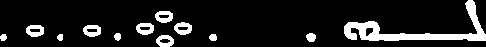

prev: [15, [True, False], None, [1290, 1319, 1316, 1337]] {'tr': 'b', 'script': '', 'dist': None}
mitchell2_test-05 15 7 [149, [False, False], None, [1320, 1317, 1338, 1339]] {'tr': 'D?', 'script': '', 'dist': None}


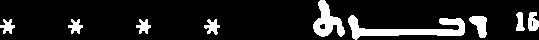

prev: [448, [False, True], None, [1106, 1478, 1157, 1518]] {'tr': 'HnN+', 'script': '', 'dist': None}
mitchell2_test-05 17 7 [449, [True, False], None, [1157, 1484, 1168, 1502]] {'tr': '+H', 'script': '', 'dist': None}


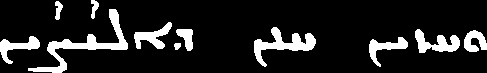

prev: [505, [False, False], None, [222, 1562, 281, 1618]] {'tr': 'K', 'script': '', 'dist': None}
mitchell2_test-05 42 1 [506, [False, False], None, [267, 1559, 396, 1584]] {'tr': 'mbD?', 'script': '', 'dist': None}


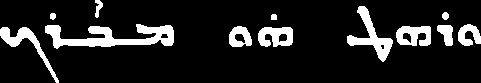

prev: [506, [False, False], None, [267, 1559, 396, 1584]] {'tr': 'mbD?', 'script': '', 'dist': None}
mitchell2_test-05 42 2 [47, [False, False], None, [272, 1548, 278, 1555]] {'tr': '^?', 'script': '', 'dist': None}


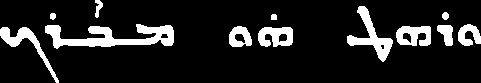

prev: [47, [False, False], None, [272, 1548, 278, 1555]] {'tr': '^?', 'script': '', 'dist': None}
mitchell2_test-05 42 3 [48, [False, False], None, [317, 1535, 325, 1553]] {'tr': '', 'script': '', 'dist': None}


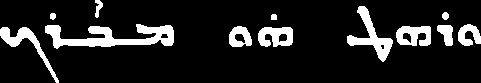

prev: [468, [False, True], None, [222, 1879, 266, 1909]] {'tr': "'", 'script': '', 'dist': None}
mitchell2_test-05 46 1 [59, [True, True], None, [271, 1892, 283, 1909]] {'tr': '+H', 'script': '', 'dist': None}


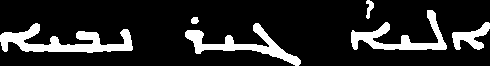

In [43]:
##### search for ambiguously encoded characters
page = 0
for basename, img_file, lines_file, textlines_file in get_filenames():
    if page > 4:
        break
    page += 1
#     im = Im(img_file)
    with open(lines_file, 'r') as f:
        lines = json.load(f)
    with open(textlines_file, 'r') as f:
        text = json.load(f)
        
    for line, textline in zip(lines, text):
        if line['type'] != 'column':
            continue
        textsize = get_textsize(line['type'], section)
        table = tables[textsize]
        stack = None
        for i, entry in enumerate(textline[section]):
            c_id, connections, keyoverride, box = entry
            tr = table[c_id]['key']['tr'] if table[c_id]['key'] else None
            script = table[c_id]['key']['script'] if table[c_id]['key'] else None
            pr_tr = table[stack[0]]['key']['tr'] if stack and table[stack[0]]['key'] else None
            if ((pr_tr and pr_tr[-1] == '+' and tr != '+' + pr_tr[:-1])
                or ('+' in tr[:-1] and (not pr_tr or not '+' in pr_tr))
                or '?' in tr or (pr_tr and pr_tr[0] == '^') or (script == '' and tr.endswith('>'))):
                if stack:
                    print('prev:', stack, table[stack[0]]['key'])
                print(basename, line['num'], i, entry, table[c_id]['key'])
                im = Im(img_file)
                display(im.crop(line['main']))
            stack = entry

In [58]:
# tables['normal'][269]['avgim']
base64_avgim = tables['normal'][31]['avgim']
AvgIm(base64_avgim['base64_str'],
        base64_avgim['baseline'],
        base64_avgim['width'],
        base64_avgim['height']).maxtoblack(invert=True)

# for ch in tables['normal']:
#     if ch['key'] and ch['key']['tr'] == 'N+':
#         base64_avgim = ch['avgim']
#         AvgIm(base64_avgim['base64_str'],
#                 base64_avgim['baseline'],
#                 base64_avgim['width'],
#                 base64_avgim['height']).maxtoblack(invert=True)

        

In [ ]:
# combinations exodus:
# ((':', '@', ':'), ':÷÷:') -> ornament in inscriptio (111_2L line 1) # or just replace with '@' (✢)?


from syrocr import gettext
from importlib import reload
gettext = reload(gettext)

### GENESIS ###
json_textlines_dir = '../analyzevts/scans/genesis-exodus/genesis/a'
tables_filename = '../analyzevts/scans/genesis-exodus/genesis/a/test_tables.json'

combinations = [
    (('^g', '+s"'), 's"g'),
    (('H+', 'y'), 'H'),
    (('l', '+T'), 'T'),
    (('n^', '"?'), 'n"'),
    (('y"+', '"?'), 'y"'), # yudh with one dot, followed by single dot
    (('y"n+', '+n"'), 'n"n'), # nun with stolen dot, followed by nun with one dot
    (('y"n+', 'y', '"?'), 'y"n'), # nun with stolen dot, followed by yudh, followed by single dot
    (('y^', '"?'), 'y"'), # yudh with one dot, followed by single dot
    (('z"+', '"?'), 'z"'),
    (('z^', '"?'), 'z"'),
    # fix for c_id 103, dot below,
    # which for some reason is not always
    # connected with its character.
    (('S', '#>'), 'S#'),
    (('h', '#>'), 'h#')]

corrections = [
    # ((basename, line, pos, c_id), override)
    (('vts-036_1R', 20, 1, 174), ''),
    (('vts-047_2L', 13, 41, 214), ''),
    (('vts-062_2L', 6, 0, 174), ''),
    (('vts-063_2L', 11, 38, 214), ''),
    (('vts-065_2L', 1, 37, 349), ''),
    (('vts-073_1R', 1, 2, 174), '.'),
    (('vts-080_1R', 11, 38, 349), '^.'),
    # these four below are for two Het that are seen as twice two yudh
    (('vts-063_2L', 6, 21, 346), ''),
    (('vts-063_2L', 6, 22, 11), 'H'),
    (('vts-086_1R', 4, 13, 346), ''),
    (('vts-086_1R', 4, 14, 11), 'H'),
    # fix for c_id 103, full stop (below baseline).
    # This shall be fixed when the isolated dot below
    # will be properly connected with he and Sade
    # (see combinations), and it can be encoded
    # independently as full stop.
    (('vts-041_2L', 17, 0, 103), '=.'),
    (('vts-066_2L', 14, 0, 103), '=.'),
    # fix for initial yudh recognized as 'o' (interpunction symbol)
    # Real fix: by looking at connections at 'compare()' stage?
    (('vts-051_1R', 11, 22, 38), 'y'),
    # Fix typo in edition: y`bwb -> y`qwb
    (('vts-062_1R', 6, 2, 16), 'q')]

spaces_file = 'Genesis.pil'

### EXODUS ###
json_textlines_dir = '../analyzevts/scans/genesis-exodus/exodus/lines'
tables_filename = '../analyzevts/scans/genesis-exodus/exodus/lines/test_tables.json'

combinations = [
    (('"?', '+s"'), 's"'),
    (('"\'+', 'r'), 'r"\''),
    (('=.', '^?'), '=/'),
    (('b', '"?'), 'b^'),
    (('b', '"?', '+s"'), 's"b'),
    (('b"+', '+w"'), 'w"b'),
    (('D?', '"?'), 'r'),
    (('g+', '#>'), 'g'), ### broken gamal
    (('k', '"?'), 'k^'),
    (('l', '"?'), 'l"'),
    (('l+', 'n'), 'l'),
    (('l+', 't'), 'tl'),
    (('N', '^?'), 'N^'),
    (('p"?', 'k"?'), 'k"p'),
    (('q#', '"?'), '^q#'),
    (('q^', '"?'), 'q"'),
    (('w', '"?'), 'w^'),
    (('y', '"?'), 'y^'),
    (('y"+', '"?'), 'y"'),
    (('y"n+', '+y"#'), 'y"#n'),
    (('y"n+', 'y', '"?'), 'y"n'),
    (('y"n+', 'y'), 'y^n'),
    (('y"n+', 'y^'), 'y"n'),
    (('y"n+', 'n^'), 'n"n'),
    (('y^', '"?'), 'y"'),
    (('z^', '"?'), 'z"'),
    (("'+", '#>', "+'"), "'#"),
    (("'+", '^.', "+'"), "'"),
    (("'+", "+'#"), "'#"),
    # misplaced dot
    (('S','#>'),'S#'),
    (('p','#>'),'p#'),
    (('h','#>'),'h#'),
    (('w','#>'),'w#'),
    (('N','#>'),'N#'),
    (('n','#>'),'n#'),
    (('M','#>'),'M#'),
    (('b','#>'),'b#'),
    (('y','#>'),'y#'),
    (('\'','#>'),'\'#'),
    (('y?','#>'),'y#'),
    (('m','#>'),'m#'),
    (('l','#>'),'l#'),
    (('T','#>'),'T#'),
    (('$','#>'),'$#'),
    (('H','#>'),'H#'),
    (('d','#>'),'d#'),
    (('t','#>'),'t#'),
    (('q','#>'),'q#'),
    (('s','#>'),'s#'),
    (('r','#>'),'r#'),
]


corrections = [
    # next two correct misprint: missing paren in edition 
    (('vts-089_2L', 18, 0, 133), '('),
    (('vts-089_2L', 18, 1, 42), '15'),
    (('vts-091_1R', 6, 35, 436), '^.'),
    (('vts-089_1R', 13, 20, 279), 'y^'),
    (('vts-092_1R', 17, 22, 279), 'y^'),       
    (('vts-093_2L', 9, 0, 436), '=.'),
    (('vts-117_2L', 6, 10, 161), 'y^'),
    (('vts-120_1R', 6, 14, 174), '=.'),
    # these four below are for two Het that are seen as twice two yudh
    (('vts-115_1R', 1, 17, 346), ''),
    (('vts-115_1R', 1, 18, 11), 'H'),
    (('vts-121_2L', 9, 34, 346), ''),
    (('vts-121_2L', 9, 35, 11), 'H'),
]

spaces_file = 'Exodus.pil'

### LEVITICUS ###
json_textlines_dir = '../analyzevts/scans/vts.1.2.leviticus.numbers.deuteronomy/a.leviticus/lines'
tables_filename = '../analyzevts/scans/vts.1.2.leviticus.numbers.deuteronomy/a.leviticus/lines/test_tables.json'

combinations = [
    (('z^', '^?'), 'z"'),
    (('y^', '^?'), 'y"'),
    (('n^', '^?'), 'n"'),
    (("^'?", 'r'), 'r"\''),
    (('D?', '^?'), 'r'),
    (('^N+', 'y', '^?'), 'y"N'),
    (('^N+', 'y^'), 'y"N'),
    (('^K', 'y^'), 'y"K'),
    (('^?', 'y^'), 'y"'),
]
corrections = []

spaces_file = 'Leviticus.pil'
"""
Lv
1:8 ry$' -> r$'
1:11 grbyh -> grbyyh
2:9 llmdbH' -> lmdbH' (variant fout)
2:12 r"y$yt' -> r"$yt'
3:13 ry$h^ -> r$h^
4:2 kl -> kwl
4:4 ry$h -> r$h
4:9 d`lyhwn -> d`lyhyn
4:12 npqywhy -> wnpqywhy
4:14 klh^ -> kwlh^
4:14 wnytwnyhy -> wnytwnh
4:15 wnkswnhy -> wnkswnyhy
4:22 klhwn -> kl
4:34 dmh -> dm'
5:6 Spryt' -> Sypryt'
6:16 wklh -> wkwlh
7:1 qwd$ -> qdw$
7:4 wtrbhwn -> wtrbhyn
7:10 dmttpyl -> dmtpyl
7:16 w'p -> 'p
7:18 dt'kwly -> dt'kwl
7:18 tqbly -> tqbl
7:21 tqrwby -> tqrwb
7:27 dt'kwly -> dt'kwl
7:30 wtrb' -> trb'
7:30 pwr$nh -> pwr$n'
8:22 dtr"tyn -> dtr"yn
( * PIL heeft hier een variant: dtr"tyn [dtr"yn/L] -- wil dat zeggen dat M en U wel dtr"tyn hebben?)
8:29 wmn -> mn
9:20 lmdbH' -> lmdb' (wrsch fout in editie? niet aangepast in diff)
10:6 r"y$ykwn -> r"$ykwn
11:21 r"glywhy -> r"glwhy
11:27 wklh^ -> klh^
11:33 kl -> kwl
15:24 `lwhy -> `lhwy (wrsch fout in editie? niet aangepast in diff)
21:2-3 wbHth=. van eind vers 2 naar begin vers 3
21:17 ldr"hwn -> ldr"yhwn
22:6 l' -> wl'
25:26 b'"ydhy -> b'"ydwhy
"""
# err in ocr:
# 22:24 wdrySS -> wdrSyS

chapter = 0
for tag, verse in gettext.verses(json_textlines_dir, tables_filename,
#         meta=False, interp=True, diacr=True, inscr=True,
        meta=False, interp=False, diacr=False, inscr=False,
#         spaces_file=spaces_file,
        combinations=combinations, corrections=corrections):
#     print(f'{tag}\t{verse}')
    v = tag.strip('()')
    if ' ' in v:
        if chapter > 0:
            print()
        ch, v = v.split()
        chapter += 1
        print(f'@Lv{chapter}')
    print(f' {v:>2}', ''.join(verse.split()))

In [ ]:
img_file = json_textlines_dir = '../analyzevts/scans/genesis-exodus/exodus/vts-110_1R.tif'
im=Im(img_file)
baseline = 1149
box = [429,1111,1923,1186]
# im

for entry in table:
    entry['avgim'] = AvgIm(
        entry['avgim']['base64_str'],
        entry['avgim']['baseline'],
        entry['avgim']['width'],
        entry['avgim']['height'])


textline = []
from syrocr.getchars import getcharacters, findchar
for char, connections in getcharacters(im, box, baseline):
    x, y = char.offset
    box = (x, y, x + char.width, y + char.height)
    tr_override = None

    c = findchar(table, char, update_avgim=False, add_to_table=False)

    textline.append((c['id'], connections, tr_override, box))


In [ ]:
textline

In [ ]:
import json
print(json.dumps(textline, indent=2))

In [ ]:
testName = 'testconfig'
import importlib
mod = importlib.import_module(testName)
print(mod.combinations, mod.corrections)

teststring = """\
combinations:
  - [['^g', '+s"'], 's"g']
  - [['H+', 'y'], 'H']
  - [['l', '+T'], 'T']
  - [['n^', '"?'], 'n"']
  - [['y"+', '"?'], 'y"'] # yudh with one dot, followed by single dot
  - [['y"n+', '+n"'], 'n"n'] # nun with stolen dot, followed by nun with one dot
  - [['y"n+', 'y', '"?'], 'y"n'] # nun with stolen dot, followed by yudh, followed by single dot
  - [['y^', '"?'], 'y"'] # yudh with one dot, followed by single dot
  - [['z"+', '"?'], 'z"']
  - [['z^', '"?'], 'z"']
    # fix for c_id 103, dot below,
    # which for some reason is not always
    # connected with its character.
  - [['S', '#>'], 'S#']
  - [['h', '#>'], 'h#']

corrections:
    # [[basename, line, pos, c_id], override]
  - [['vts-036_1R', 20, 1, 174], '']
  - [['vts-047_2L', 13, 41, 214], '']
  - [['vts-062_2L', 6, 0, 174], '']
  - [['vts-063_2L', 11, 38, 214], '']
  - [['vts-065_2L', 1, 37, 349], '']
  - [['vts-073_1R', 1, 2, 174], '.']
  - [['vts-080_1R', 11, 38, 349], '^.']
  - # these four below are for two Het that are seen as twice two yudh
  - [['vts-063_2L', 6, 21, 346], '']
  - [['vts-063_2L', 6, 22, 11], 'H']
  - [['vts-086_1R', 4, 13, 346], '']
  - [['vts-086_1R', 4, 14, 11], 'H']
  - # fix for c_id 103, full stop [below baseline].
  - # This shall be fixed when the isolated dot below
  - # will be properly connected with he and Sade
  - # [see combinations], and it can be encoded
  - # independently as full stop.
  - [['vts-041_2L', 17, 0, 103], '=.']
  - [['vts-066_2L', 14, 0, 103], '=.']
  - # fix for initial yudh recognized as 'o' [interpunction symbol]
  - # Real fix: by looking at connections at 'compare[]' stage?
  - [['vts-051_1R', 11, 22, 38], 'y']
  - # Fix typo in edition: y`bwb -> y`qwb
  - [['vts-062_1R', 6, 2, 16], 'q']
"""
import yaml
config = yaml.safe_load(teststring)

print(config)

In [29]:
# scan missed line
from syrocr import getchars
from syrocr.images import Im
import json

im = Im('../analyzevts/scans/genesis-exodus/exodus/vts-088_2L.tif')
baseline = 621
linebox = [739, 591, 1629, 638]

with open('../analyzevts/scans/genesis-exodus/exodus/lines/test_tables.json', 'r') as f:
    tables = json.load(f)
table = tables['normal']
for c in table:
    if type(c['avgim']) is dict:
        c['avgim'] = AvgIm(c['avgim']['base64_str'], c['avgim']['baseline'], c['avgim']['width'], c['avgim']['height'])

        chars = []
for char, connections in getchars.getcharacters(im, linebox, baseline):
    x, y = char.offset
    box = (x, y, x + char.width, y + char.height)
    tr_override = None
    c = getchars.findchar(tables['normal'], char, update_avgim=False, add_to_table=False)
    chars.append((c['id'], connections, tr_override, box))

print(json.dumps(chars, indent=2))

[
  [
    157,
    [
      false,
      false
    ],
    null,
    [
      739,
      599,
      772,
      626
    ]
  ],
  [
    68,
    [
      false,
      false
    ],
    null,
    [
      792,
      592,
      807,
      632
    ]
  ],
  [
    84,
    [
      false,
      false
    ],
    null,
    [
      828,
      602,
      833,
      622
    ]
  ],
  [
    6,
    [
      false,
      false
    ],
    null,
    [
      841,
      594,
      879,
      621
    ]
  ],
  [
    0,
    [
      false,
      true
    ],
    null,
    [
      881,
      591,
      906,
      622
    ]
  ],
  [
    12,
    [
      true,
      false
    ],
    null,
    [
      917,
      610,
      926,
      621
    ]
  ],
  [
    5,
    [
      false,
      false
    ],
    null,
    [
      933,
      593,
      949,
      623
    ]
  ],
  [
    1,
    [
      false,
      false
    ],
    null,
    [
      954,
      603,
      975,
      622
    ]
  ],
  [
    6,
    [
      false,
      false
 

In [17]:
# print line for reference
im = Im('../analyzevts/scans/vts.1.2.leviticus.numbers.deuteronomy/c.deuteronomy/peshitta1_2c-058_1R.tif')
with open('../analyzevts/scans/vts.1.2.leviticus.numbers.deuteronomy/c.deuteronomy/lines/peshitta1_2c-058_1R_textlines.json') as f:
    lines = json.load(f)
for i, c in enumerate(lines[6]['main']):
    print(i, c, table[c[0]]['key']['tr'])

0 [7, [False, False], None, [330, 615, 335, 620]] =.
1 [260, [False, True], None, [345, 613, 360, 633]] x
2 [432, [False, False], None, [361, 632, 367, 637]] 
3 [20, [True, True], None, [366, 601, 385, 620]] $
4 [23, [True, False], None, [389, 603, 421, 620]] `
5 [6, [False, False], None, [427, 600, 444, 622]] d
6 [11, [False, True], None, [488, 591, 528, 621]] '
7 [17, [True, True], None, [538, 603, 563, 621]] b
8 [17, [True, False], None, [569, 603, 594, 621]] b
9 [6, [False, True], None, [601, 599, 617, 622]] d
10 [25, [True, True], None, [620, 580, 632, 622]] l
11 [44, [True, True], None, [641, 603, 659, 622]] `
12 [17, [True, False], None, [672, 603, 697, 622]] b
13 [6, [False, False], None, [704, 599, 721, 622]] d
14 [1, [False, False], None, [765, 592, 805, 620]] '
15 [157, [False, True], None, [807, 600, 830, 622]] z
16 [63, [True, False], None, [830, 597, 881, 636]] g
17 [5, [False, False], None, [872, 600, 895, 620]] w
18 [4, [False, False], None, [903, 590, 918, 622]] r
19 [